<a href="https://colab.research.google.com/github/Mechanics-Mechatronics-and-Robotics/CV-2025/blob/main/projects/Shapes_and_CAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Request to Deep Seek model
Dear model, lets make a plan for coding. We need to check if a CAE can interpolate geometry accurate enough with a toy dataset.
A raw plan is as follows (please be critical and feel free to correct it):
- generate synthetic dataset of squares of different positions and areas (no rotations required so far);
- split the dataset into training, validation, and test sets;
- create a simple CAE model;
- train the model to reconstruct squares, test the model, visualize the results, save the trained encoder;
- use t-SNE to visualize the latent space as well, check if interpolation works and the squares of similar surface area are close in the latent space than the squares of dissimilar surface area;
- use the pretrained encoder and train a classifier to predict surface area of the squares, check the accuracy.

The code will be launched in Colab. Please use pytorch, lightning and clearML. Collect the model parameters in one dictionary param={}. Below you can find some fragments of the code for the initialization

!pip install pytorch-lightning clearml

%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=ZP02U03C6V5ER4K9VWRNZT7EWA5ZTV
%env CLEARML_API_SECRET_KEY=BtA5GXZufr6QGpaqhX1GSKPTvaCt56OLqaNqUGLNoxx2Ye8Ctwbui0Ln5OXVnzUgH4I

# Initialization

In [1]:
!pip install pytorch-lightning clearml #scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from clearml import Task
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [3]:
%env CLEARML_WEB_HOST=https://app.clear.ml/
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=ZP02U03C6V5ER4K9VWRNZT7EWA5ZTV
%env CLEARML_API_SECRET_KEY=BtA5GXZufr6QGpaqhX1GSKPTvaCt56OLqaNqUGLNoxx2Ye8Ctwbui0Ln5OXVnzUgH4I

env: CLEARML_WEB_HOST=https://app.clear.ml/
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=ZP02U03C6V5ER4K9VWRNZT7EWA5ZTV
env: CLEARML_API_SECRET_KEY=BtA5GXZufr6QGpaqhX1GSKPTvaCt56OLqaNqUGLNoxx2Ye8Ctwbui0Ln5OXVnzUgH4I


In [4]:
param = {
    'image_size': 64,
    'min_width': 4,
    'max_width': 32,
    'dataset_size': 10000,
    'batch_size': 32,
    'latent_dim': 32,
    'num_workers':10,
    'lr': 1e-3,
    'max_epochs': 50,
    'seed': 42,
}
# Set seeds for reproducibility
pl.seed_everything(42)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

# Data module

In [5]:
class SyntheticSquareDataset(Dataset):
    def __init__(self, param):
        self.images = torch.zeros((param['dataset_size'], 1, param['image_size'], param['image_size']))
        self.areas = torch.zeros(param['dataset_size'])
        for i in range(param['dataset_size']):
            w = torch.randint(param['min_width'], param['max_width'] + 1, (1,)).item()
            x = torch.randint(0, param['image_size'] - w + 1, (1,)).item()
            y = torch.randint(0, param['image_size'] - w + 1, (1,)).item()
            self.images[i, 0, x:x+w, y:y+w] = 1.0
            self.areas[i] = w ** 2

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.areas[idx]

dataset = SyntheticSquareDataset(param)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [6]:
train_loader = DataLoader(train_dataset, batch_size=param['batch_size'], shuffle=True, num_workers=param['num_workers'])
val_loader = DataLoader(val_dataset, batch_size=param['batch_size'], num_workers=param['num_workers'])
test_loader = DataLoader(test_dataset, batch_size=param['batch_size'], num_workers=param['num_workers'])

In [7]:
class CAE(pl.LightningModule):
    def __init__(self, latent_dim=32, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 8 * 8),
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x_hat = self(x)
        loss = F.mse_loss(x_hat, x)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        x_hat = self(x)
        loss = F.mse_loss(x_hat, x)
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        x, _ = batch
        x_hat = self(x)
        loss = F.mse_loss(x_hat, x)
        self.log('test_loss', loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [8]:
# Initialize ClearML Task
task = Task.init(project_name='CAE_Squares', task_name='CAE_Training')
task.connect(param)

ClearML Task: created new task id=93d1b9b172234d99970b62fb73524140
2025-05-13 10:20:20,888 - clearml.Task - INFO - Storing jupyter notebook directly as code
ClearML results page: https://app.clear.ml/projects/521854431e0f4b0394cdf4a950c90a12/experiments/93d1b9b172234d99970b62fb73524140/output/log


{'image_size': 64,
 'min_width': 4,
 'max_width': 32,
 'dataset_size': 10000,
 'batch_size': 32,
 'latent_dim': 32,
 'lr': 0.001,
 'max_epochs': 50,
 'seed': 42}

In [9]:
model = CAE(latent_dim=param['latent_dim'], lr=param['lr'])
trainer = pl.Trainer(max_epochs=param['max_epochs'], accelerator='auto')
trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 154 K  | train
1 | decoder | Sequential | 158 K  | train
-----------------------------------------------
312 K     Trainable params
0         Non-trainable params
312 K     Total params
1.251     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025-05-13 10:20:37,454 - clearml.frameworks - INFO - Found existing registered model id=67b1ad17f10744ef99eedd51bd685992 [/content/lightning_logs/version_0/checkpoints/epoch=0-step=250.ckpt] reusing it.


Validation: |          | 0/? [00:00<?, ?it/s]

2025-05-13 10:20:44,246 - clearml.frameworks - INFO - Found existing registered model id=9184ee619732436cb488680471ed9d49 [/content/lightning_logs/version_0/checkpoints/epoch=1-step=500.ckpt] reusing it.


Validation: |          | 0/? [00:00<?, ?it/s]

2025-05-13 10:20:50,918 - clearml.frameworks - INFO - Found existing registered model id=b051693a3e2a40c6b800c76aeb204b59 [/content/lightning_logs/version_0/checkpoints/epoch=2-step=750.ckpt] reusing it.


Validation: |          | 0/? [00:00<?, ?it/s]

2025-05-13 10:20:57,852 - clearml.frameworks - INFO - Found existing registered model id=6f38fe9dd1284c019ae67155e048e1d6 [/content/lightning_logs/version_0/checkpoints/epoch=3-step=1000.ckpt] reusing it.


Validation: |          | 0/? [00:00<?, ?it/s]

2025-05-13 10:21:04,525 - clearml.frameworks - INFO - Found existing registered model id=044221a9284d4489b02c652492cb44fd [/content/lightning_logs/version_0/checkpoints/epoch=4-step=1250.ckpt] reusing it.


Validation: |          | 0/? [00:00<?, ?it/s]

2025-05-13 10:21:11,933 - clearml.frameworks - INFO - Found existing registered model id=f255dcdd3332413cbcc6c6f5596aa02f [/content/lightning_logs/version_0/checkpoints/epoch=5-step=1500.ckpt] reusing it.


Validation: |          | 0/? [00:00<?, ?it/s]

2025-05-13 10:21:19,441 - clearml.frameworks - INFO - Found existing registered model id=7e70e577b5944974bad6002f736c3eb2 [/content/lightning_logs/version_0/checkpoints/epoch=6-step=1750.ckpt] reusing it.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │  0.00016994969337247312   │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.00016994969337247312}]

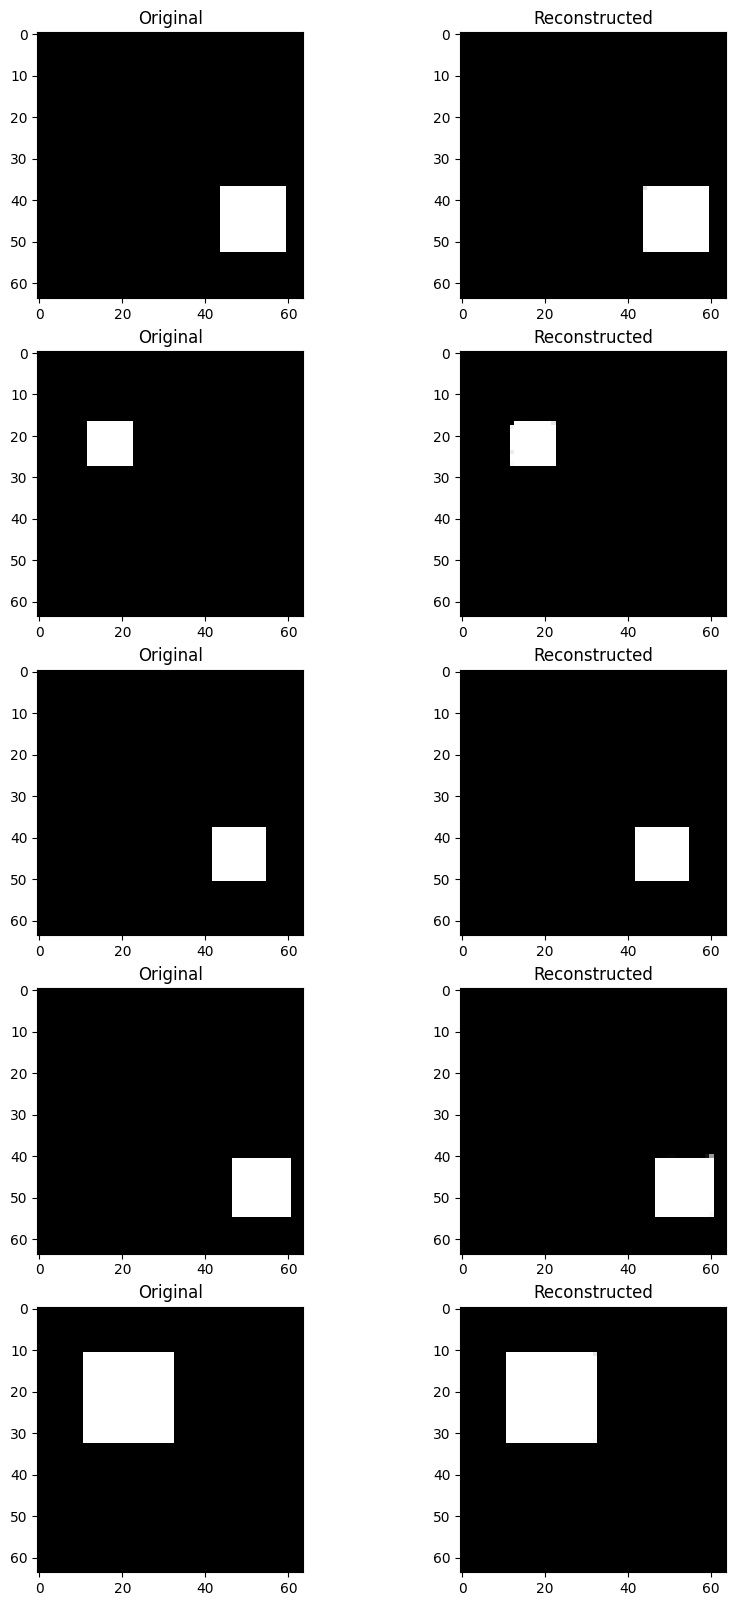

In [10]:
model.eval()
x, _ = next(iter(test_loader))
x_hat = model(x).detach()

fig, axes = plt.subplots(5, 2, figsize=(10, 20))
for i in range(5):
    axes[i,0].imshow(x[i].squeeze(), cmap='gray')
    axes[i,0].set_title('Original')
    axes[i,1].imshow(x_hat[i].squeeze(), cmap='gray')
    axes[i,1].set_title('Reconstructed')
plt.show()
# Log images to ClearML
task.get_logger().report_matplotlib_figure(title="Reconstructions", series="Test Set", figure=fig, iteration=0)

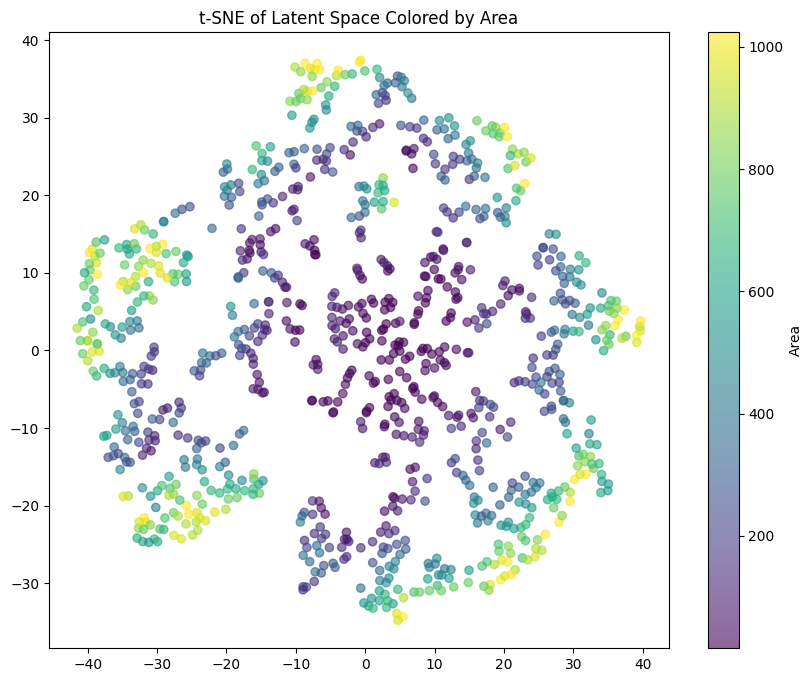

<Figure size 640x480 with 0 Axes>

In [11]:
# Extract latent vectors
latent_vectors = []
areas = []
model.eval()
with torch.no_grad():
    for x, a in test_loader:
        latent_vectors.append(model.encoder(x))
        areas.append(a)
latent_vectors = torch.cat(latent_vectors).cpu().numpy()
areas = torch.cat(areas).cpu().numpy()

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(latent_vectors)

# Plot
plt.figure(figsize=(10, 8))
plt.scatter(latent_tsne[:,0], latent_tsne[:,1], c=areas, cmap='viridis', alpha=0.6)
plt.colorbar(label='Area')
plt.title('t-SNE of Latent Space Colored by Area')
plt.show()
task.get_logger().report_matplotlib_figure(title="t-SNE", series="Latent Space", figure=plt.gcf(), iteration=0)

<ipython-input-12-ab386d8de46d>:4: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)



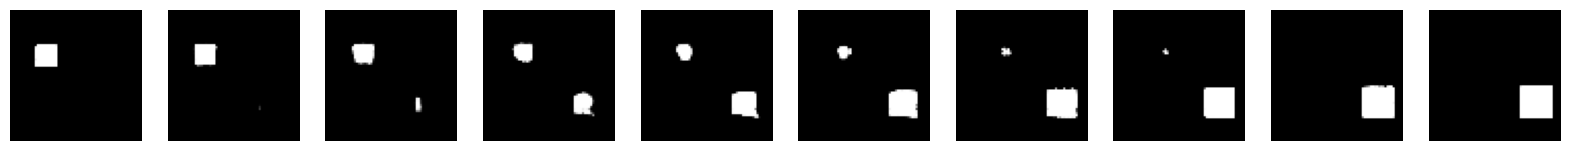

<Figure size 640x480 with 0 Axes>

In [12]:
z1 = latent_vectors[0]
z2 = latent_vectors[1]
alphas = np.linspace(0, 1, 10)
interpolated_z = torch.tensor([a * z1 + (1 - a) * z2 for a in alphas], dtype=torch.float32)

with torch.no_grad():
    interpolated_images = model.decoder(interpolated_z).cpu()

fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i, img in enumerate(interpolated_images):
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].axis('off')
plt.show()
task.get_logger().report_matplotlib_figure(title="Interpolation", series="Latent Space", figure=plt.gcf(), iteration=0)

In [13]:
class AreaRegressor(pl.LightningModule):
    def __init__(self, encoder, latent_dim, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.encoder = encoder
        for param in self.encoder.parameters():
            param.requires_grad = False
        self.regressor = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.regressor(self.encoder(x)).squeeze()

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('val_loss', loss)
        mae = torch.mean(torch.abs(y_hat - y))
        self.log('val_mae', mae)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('test_loss', loss)
        mae = torch.mean(torch.abs(y_hat - y))
        self.log('test_mae', mae)

    def configure_optimizers(self):
        return torch.optim.Adam(self.regressor.parameters(), lr=self.hparams.lr)

# Initialize and train regressor
regressor = AreaRegressor(model.encoder, param['latent_dim'], lr=param['lr'])
trainer_regressor = pl.Trainer(max_epochs=20, accelerator='auto')
trainer_regressor.fit(regressor, train_loader, val_loader)
trainer_regressor.test(regressor, test_loader)

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/parsing.py:209: UserWarning:

Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type       | Params | Mode 
-------------------------------------------------
0 | encoder   | Sequential | 154 K  | eval 
1 | r

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     30.94998550415039     │
│         test_mae          │     4.318511486053467     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 30.94998550415039, 'test_mae': 4.318511486053467}]

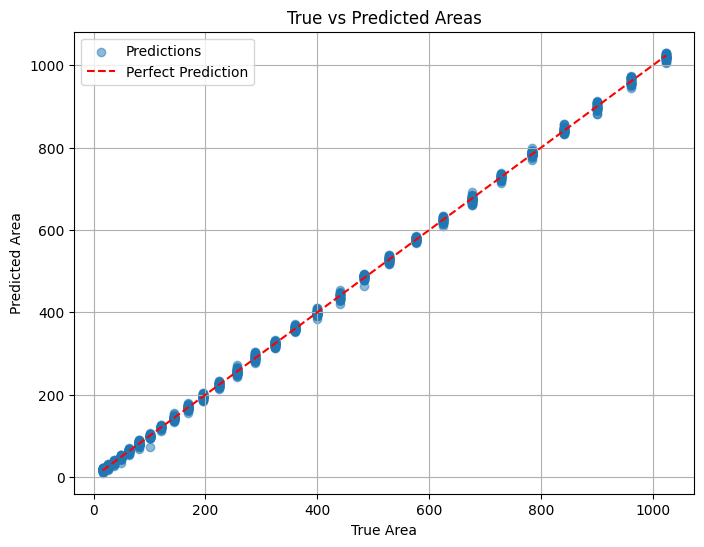

<Figure size 640x480 with 0 Axes>

In [14]:
# Collect all predictions
regressor.eval()
true_areas = []
pred_areas = []
with torch.no_grad():
    for x, y in test_loader:
        pred = regressor(x)
        true_areas.extend(y.cpu().numpy())
        pred_areas.extend(pred.cpu().numpy())

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(true_areas, pred_areas, alpha=0.5, label='Predictions')
plt.plot([min(true_areas), max(true_areas)], [min(true_areas), max(true_areas)],
         'r--', label='Perfect Prediction')
plt.xlabel('True Area')
plt.ylabel('Predicted Area')
plt.title('True vs Predicted Areas')
plt.legend()
plt.grid(True)
plt.show()
task.get_logger().report_matplotlib_figure(
    title="Regression Results",
    series="True vs Predicted",
    figure=plt.gcf(),
    iteration=0
)

/usr/local/lib/python3.11/dist-packages/clearml/utilities/plotlympl/renderer.py:210: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



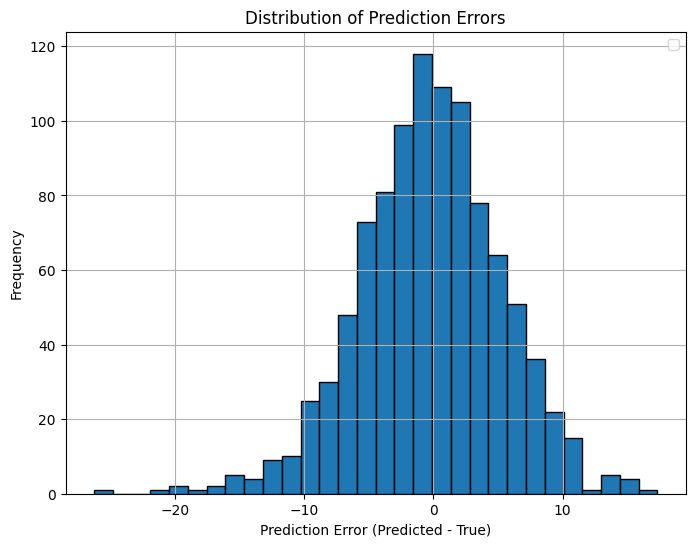

<Figure size 640x480 with 0 Axes>

In [15]:
errors = np.array(pred_areas) - np.array(true_areas)
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=30, edgecolor='black')
plt.xlabel('Prediction Error (Predicted - True)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(True)
plt.show()
task.get_logger().report_matplotlib_figure(
    title="Regression Errors",
    series="Error Distribution",
    figure=plt.gcf(),
    iteration=0
)

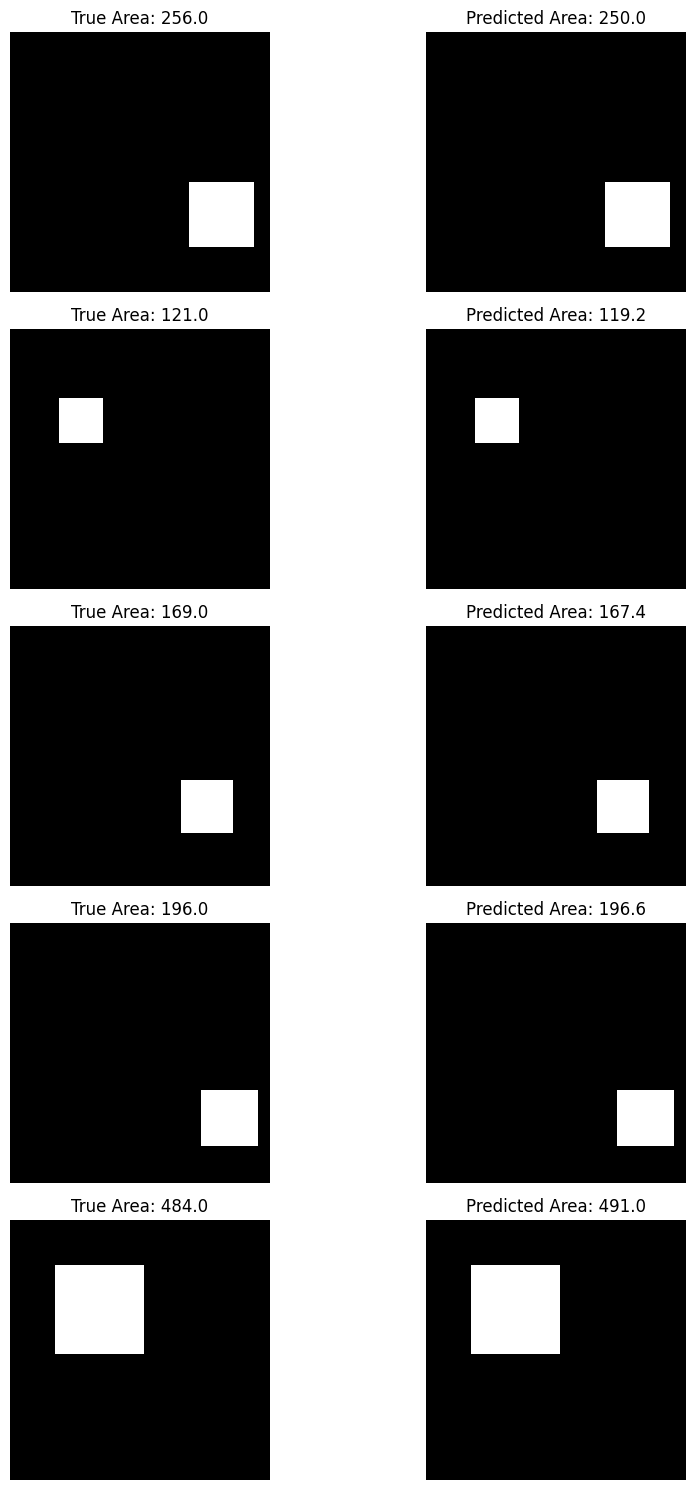

<Figure size 640x480 with 0 Axes>

In [16]:
# Get a batch of test data
x, y = next(iter(test_loader))
regressor.eval()
with torch.no_grad():
    y_pred = regressor(x[:5])  # First 5 samples

# Plot
fig, axes = plt.subplots(5, 2, figsize=(10, 15))
for i in range(5):
    # Original image
    axes[i, 0].imshow(x[i].squeeze().cpu(), cmap='gray')
    axes[i, 0].set_title(f'True Area: {y[i].item():.1f}')
    axes[i, 0].axis('off')

    # Blank (for alignment, or overlay text)
    axes[i, 1].imshow(x[i].squeeze().cpu(), cmap='gray')
    axes[i, 1].set_title(f'Predicted Area: {y_pred[i].item():.1f}')
    axes[i, 1].axis('off')
plt.tight_layout()
plt.show()
task.get_logger().report_matplotlib_figure(
    title="Sample Predictions",
    series="Test Samples",
    figure=plt.gcf(),
    iteration=0
)

In [17]:
from sklearn.metrics import r2_score, mean_absolute_error

r2 = r2_score(true_areas, pred_areas)
mae = mean_absolute_error(true_areas, pred_areas)
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")

# Log metrics to ClearML
task.get_logger().report_scalar(
    title="Regression Metrics",
    series="R² Score",
    value=r2,
    iteration=0
)
task.get_logger().report_scalar(
    title="Regression Metrics",
    series="MAE",
    value=mae,
    iteration=0
)

R² Score: 0.9997
MAE: 4.3185
